<a href="https://colab.research.google.com/github/MarcFriz/Kaggle-Earthquake_challenge/blob/master/Kaggle_Earthquake_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](https://i.imgur.com/rTadNbm.png)

# Step 1 - Install and Import

In [0]:
#to access kaggle datasets
!pip install kaggle
#Math operations
!pip install numpy
#Machine learning
!pip install catboost
!pip install keras
!pip install xgboost

    100% |████████████████████████████████| 60.0MB 704kB/s 


In [0]:
#data preprocessing
import pandas as pd
#math operations
import numpy as np
#machine learning
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import matplotlib.pyplot as plt
import math
import pickle

# Step 2 - Import Dataset from Kaggle

In [0]:
# Colab's file access feature
from google.colab import files

#retrieve uploaded file
uploaded = files.upload()

#print results
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 64 bytes


In [0]:
#download earthquake data, will take 30-60 seconds
!kaggle competitions download -c LANL-Earthquake-Prediction

  0% 0.00/33.3k [00:00<?, ?B/s]
100% 33.3k/33.3k [00:00<00:00, 58.6MB/s]
100% 241M/242M [00:01<00:00, 145MB/s]
100% 242M/242M [00:01<00:00, 135MB/s]
 99% 2.01G/2.03G [00:20<00:00, 94.5MB/s]
100% 2.03G/2.03G [00:20<00:00, 105MB/s] 


In [0]:
#unzip training data for usage, will take about 5 minutes (its big)
# !ls
!unzip train.csv.zip
!unzip test.zip
# !ls

# Step 3 -  Exploratory Data Analysis

In [0]:

#Extract training data into a dataframe for further manipulation
train = pd.read_csv('train.csv', nrows=6000000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})
train2 = pd.read_csv('train.csv',skiprows=4438800, nrows=100, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

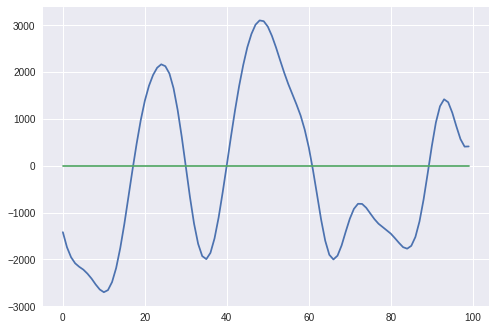

In [0]:
plt.plot(train2)

In [0]:
#print first 10 entries
train.head(10)

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691
5,8,1.4691
6,9,1.4691
7,7,1.4691
8,-5,1.4691
9,3,1.4691


(60000,)


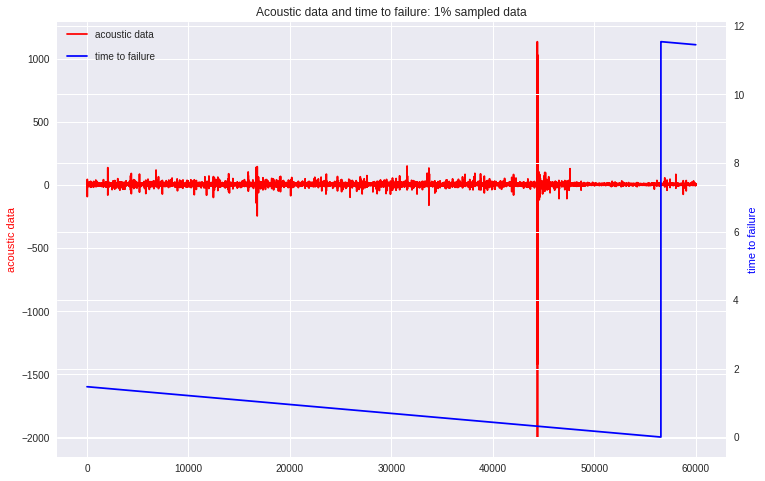

In [0]:
#visualize 1% of samples data, first 100 datapoints
train_ad_sample_df = train['acoustic_data'].values[::100]
train_ttf_sample_df = train['time_to_failure'].values[::100]

print(train_ad_sample_df.shape)

#function for plotting based on both features
def plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df, title="Acoustic data and time to failure: 1% sampled data"):
    fig, ax1 = plt.subplots(figsize=(12, 8))
    plt.title(title)
    plt.plot(train_ad_sample_df, color='r')
    ax1.set_ylabel('acoustic data', color='r')
    plt.legend(['acoustic data'], loc=(0.01, 0.95))
    ax2 = ax1.twinx()
    plt.plot(train_ttf_sample_df, color='b')
    ax2.set_ylabel('time to failure', color='b')
    plt.legend(['time to failure'], loc=(0.01, 0.9))
    plt.grid(True)

plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df)
del train_ad_sample_df
del train_ttf_sample_df

# Step 4 - Feature Engineering

In [0]:
from sklearn.linear_model import LinearRegression

def add_trend_feature(arr, abs_values=False):
    idx = np.array(range(len(arr)))
    if abs_values:
        arr = np.abs(arr)
    lr = LinearRegression()
    lr.fit(idx.reshape(-1, 1), arr)
    return lr.coef_[0]

In [0]:
#lets create a function to generate some statistical features based on the training data
def gen_features(X):
    strain = []
    strain.append(X.mean())
    strain.append(X.std())
    strain.append(X.min())
    strain.append(X.max())
    strain.append(X.kurtosis())
    strain.append(X.skew())
    strain.append(np.abs(X).max())
    strain.append(np.abs(X).mean())
    strain.append(np.abs(X).std())
    
    strain.append(X.quantile(0.95))
    strain.append(X.quantile(0.99))
    strain.append(X.quantile(0.05))
    strain.append(X.quantile(0.01))
    strain.append(add_trend_feature(X))
    
    return pd.Series(strain)

In [0]:
train = pd.read_csv('train.csv', iterator=True, chunksize=150_000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

X_train = pd.DataFrame()
y_train = pd.Series()
for df in train:
    ch = gen_features(df['acoustic_data'])
    X_train = X_train.append(ch, ignore_index=True)
    y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))

In [0]:
X_train.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
count,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4.195000e+03
mean,4.519475,6.547788,-149.190942,163.522288,68.297997,0.125830,170.046246,5.547367,5.750165,11.231716,20.321890,-2.184779,-11.224603,9.810856e-09
std,0.256049,8.503939,265.087984,272.930331,70.532565,0.477901,296.887015,1.517038,8.339211,2.358067,14.225526,2.346558,14.106852,1.863566e-06
min,3.596313,2.802720,-5515.000000,23.000000,0.648602,-4.091826,23.000000,4.147707,2.589085,9.000000,11.000000,-39.000000,-336.000000,-8.239300e-06
25%,4.349497,4.478637,-154.000000,92.000000,28.090227,-0.040779,94.000000,5.061843,3.862810,10.000000,15.000000,-3.000000,-14.000000,-1.189593e-06
50%,4.522147,5.618798,-111.000000,123.000000,45.816625,0.085620,127.000000,5.380853,4.781513,11.000000,19.000000,-2.000000,-10.000000,2.777315e-08
75%,4.693350,6.880904,-79.000000,170.000000,78.664202,0.253930,175.000000,5.748553,5.887947,12.000000,23.000000,-1.000000,-6.000000,1.240012e-06
max,5.391993,153.703569,-15.000000,5444.000000,631.158927,4.219429,5515.000000,32.762073,150.432368,50.000000,337.000000,0.000000,-2.000000,9.528734e-06


In [0]:
X_train.shape

(4195, 14)

In [0]:
X_train.size

58730

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)

In [0]:
X_test = X_train.copy()
y_test = y_train.copy()

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

# Step 5 - Implement Catboost Model

In [0]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
with tf.device('/gpu:0'):
  train_pool = Pool(X_train, y_train)
  m = CatBoostRegressor(iterations=20000, learning_rate=0.01, loss_function='MAE', boosting_type='Ordered')
  m.fit(X_train_1, y_train_1, eval_set=(X_test_1, y_test_1),silent=True,  cat_features=[], use_best_model=True)
  print(m.best_score_)

{'learn': {'MAE': 1.857273271865578}, 'validation_0': {'MAE': 1.9781960956906632}}


In [0]:
# Test
metrics.mean_absolute_error(y_test_1, m.predict(X_test_1))

1.9781960974270305

In [0]:
# Train
metrics.mean_absolute_error(y_train_1, m.predict(X_train_1))

1.8573415728816056

# Step 6 - Implement XGBoost

In [0]:
import xgboost as xgb

with tf.device('/gpu:0'):
  gbm = xgb.XGBRegressor()
  reg_cv = GridSearchCV(gbm, {"colsample_bytree":[1.0],"min_child_weight":[1.0,1.2]
                              ,'max_depth': [3,4], 'n_estimators': [500,1000]}, verbose=1)
  reg_cv.fit(X_train,y_train)

In [0]:
reg_cv.best_params_

{'colsample_bytree': 1.0,
 'max_depth': 3,
 'min_child_weight': 1.0,
 'n_estimators': 500}

In [0]:
import xgboost as xgb

with tf.device('/gpu:0'):
  gbm = xgb.XGBRegressor(**reg_cv.best_params_)
  gbm.fit(X_train_1,y_train_1, eval_metric='mae')
  metrics.mean_absolute_error(y_train_1, gbm.predict(X_train_1))

In [0]:
metrics.mean_absolute_error(y_train_1, gbm.predict(X_train_1))

0.008813934424978985

In [0]:
metrics.mean_absolute_error(y_test_1, gbm.predict(X_test_1))

2.304713052743249

# Step 7 - Implement Random Forest

In [0]:
from sklearn.ensemble import RandomForestRegressor

with tf.device('/gpu:0'):
  regr = RandomForestRegressor(max_depth=2, random_state=0, n_estimators=100)
  regr.fit(X_train, y_train)
  metrics.mean_absolute_error(y_train_1, regr.predict(X_train_1))

In [0]:
metrics.mean_absolute_error(y_test_1, regr.predict(X_test_1))

2.223963930063414

# Step 8 - Implement Lasso

In [0]:
from sklearn.linear_model import Lasso

with tf.device('/gpu:0'):
  regLasso = linear_model.Lasso(alpha=0.1)
  regLasso.fit(X_train_1, y_train_1)
  metrics.mean_absolute_error(y_train, regLasso.predict(X_train))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [0]:
metrics.mean_absolute_error(y_test_1, regLasso.predict(X_test_1))

2.404114902159918

# Step 9 - Implement KernelRidge

In [0]:
from sklearn.kernel_ridge import KernelRidge

with tf.device('/gpu:0'):
  krr = KernelRidge(alpha=1.0)
  krr.fit(X_train_1, y_train_1)
  metrics.mean_absolute_error(y_train_1, krr.predict(X_train_1))

In [0]:
metrics.mean_absolute_error(y_test_1, krr.predict(X_test_1))

2.423084555305827

# Step 10 - Implement MLPRegressor

In [0]:
from sklearn.neural_network import MLPRegressor, MLPClassifier

with tf.device('/gpu:0'):
  mlp = MLPRegressor(500)
  mlp.fit(X_train_1, y_train_1)
  metrics.mean_absolute_error(y_train, mlp.predict(X_train))

In [0]:
metrics.mean_absolute_error(y_test_1, mlp.predict(X_test_1))

2.721030219029483

# Steb 11 - Implement ADA

In [0]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

with tf.device('/gpu:0'):
  decisionReg = DecisionTreeRegressor(max_depth=10)
  rng = np.random.RandomState(1)
  adaReg = AdaBoostRegressor(decisionReg, n_estimators=400, random_state=rng)
  adaReg.fit(X_train_1, y_train_1)

In [0]:
metrics.mean_absolute_error(y_test_1, adaReg.predict(X_test_1))

2.279052295803501

# Step 12 - Implement SVR

In [0]:
from sklearn.svm import LinearSVR

regrSVR = LinearSVR(random_state=0, tol=1e-5, loss='squared_epsilon_insensitive', max_iter=100)
regrSVR.fit(X_train_1, y_train_1)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='squared_epsilon_insensitive',
     max_iter=100, random_state=0, tol=1e-05, verbose=0)

In [0]:
metrics.mean_absolute_error(y_test_1, gpr.predict(X_test_1))

2.273783607566689

# Step 13 - Scaler

In [0]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding,  Dropout
from keras import losses
import tensorflow as tf

import keras

In [0]:
from sklearn.preprocessing import StandardScaler

# Step 14 - ANN

In [0]:
import numpy as np 
import pandas as pd 

from sklearn.metrics import mean_absolute_error

from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras import optimizers
import keras

In [0]:
# Colab's file access feature
from google.colab import files

#retrieve uploaded file
uploaded = files.upload()

Saving model_ANN.h5 to model_ANN.h5


In [0]:
NN_model.load_weights('model.h5')

In [0]:
def gen_features1(X):
    features = []
    
    X1 = X[:75000]
    X2 = X[75000:]
    
    for segment in (X1, X2):
        features.append(segment.min()) 
        features.append(segment.max())
    
        for i in range(2,99):
            features.append(X.quantile(i/100))
            
        for i in range(10):
            features.append(X.quantile((990+i)/1000))
            features.append(X.quantile((1+i)/1000))        
        
        features.append(segment.mean())
        features.append(segment.std())
        features.append(segment.mad())
        features.append(segment.skew())
        features.append(segment.kurtosis())
        
        features.append(np.sqrt(np.mean(segment**2)))
        
        features.append(np.abs(segment).mean())
        features.append(np.abs(segment).std())
    
        features.append(np.abs(np.diff(segment)).mean())
        features.append(np.abs(np.diff(segment)).std())
        
    return pd.Series(features)

In [0]:
train = pd.read_csv('train.csv', 
                    iterator=True, 
                    chunksize=30_000, 
                    dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

X_train = pd.DataFrame()
y_train = pd.Series()

df = pd.DataFrame()
i = 0
for chunk in train:
    i += 1
    if not i%1000:
        print(i)
        
    df = df.append(chunk)
    if len(df) >= 150000:        
        df = df[-150000:]
        ch = gen_features1(df['acoustic_data'])    
        X_train = X_train.append(ch, ignore_index=True)
        y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000


In [0]:
X_train_1.shape

(16774, 258)

In [0]:
log2 = {}

In [0]:
scores = []
preds = []
count = 0

for j in range(1):
  epoch = 33 + j
  for i in range(5):
      NN_model = Sequential()
      count = count + 1

      NN_model.add(Dense(300, kernel_initializer='normal', input_dim = X_train.shape[1]))
      NN_model.add(BatchNormalization())
      NN_model.add(Activation('tanh'))
      NN_model.add(Dropout(0.25))

      NN_model.add(Dense(128, kernel_initializer='normal'))
      NN_model.add(BatchNormalization())
      NN_model.add(Activation('tanh'))
      NN_model.add(Dropout(0.25))

      NN_model.add(Dense(64, kernel_initializer='normal')) 
      NN_model.add(BatchNormalization())
      NN_model.add(Activation('tanh'))
      NN_model.add(Dropout(0.25))

      NN_model.add(Dense(32, kernel_initializer='normal'))    
      NN_model.add(Activation('tanh'))

      NN_model.add(Dense(1, kernel_initializer='normal'))    
      NN_model.add(Activation('linear'))

  #     adam = keras.optimizers.Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

  #     NN_model.compile(loss='mean_absolute_error', optimizer=adam, metrics=['mean_absolute_error'])
      NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

      NN_model.fit(X_train_1, y_train_1, epochs=epoch, batch_size=32)

      cur_preds = NN_model.predict(X_test_1).clip(0,16.1) 
      preds.append(cur_preds)

      cur_score = mean_absolute_error(y_test_1, cur_preds)
      scores.append(cur_score)
      print(cur_score)
      log2[count]= {'mae' : mean_absolute_error(y_test_1, cur_preds), 'epoch' : epoch,  'model' : NN_model} 
    
print("========================") 

print(np.mean(scores))

print("========================") 

preds = np.hstack([p.reshape(-1,1) for p in preds])
preds = np.mean(preds, axis=1)

# log

In [0]:
log2#[2]['mae']

{1: {'epoch': 33,
  'mae': 1.9984276509855117,
  'model': <keras.engine.sequential.Sequential at 0x7f75249f7a58>},
 2: {'epoch': 33,
  'mae': 1.9947789836373528,
  'model': <keras.engine.sequential.Sequential at 0x7f7522578e48>},
 3: {'epoch': 33,
  'mae': 1.9998951623939625,
  'model': <keras.engine.sequential.Sequential at 0x7f752169ecc0>},
 4: {'epoch': 33,
  'mae': 2.000298597618467,
  'model': <keras.engine.sequential.Sequential at 0x7f7520748cf8>},
 5: {'epoch': 33,
  'mae': 1.9967920191314794,
  'model': <keras.engine.sequential.Sequential at 0x7f751f86ef98>}}

In [0]:
save(log2[2]['model'])

Saved model to disk


In [0]:
metrics.mean_absolute_error(y_test_1, log[21]['model'].predict(X_test_1))

2.1258820409653083

In [0]:
save(NN_model)

Saved model to disk


# Step X - Implement LSTM

In [0]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding
from keras import losses
import tensorflow as tf

import keras

Using TensorFlow backend.


In [0]:
# Colab's file access feature
from google.colab import files

#retrieve uploaded file
uploaded = files.upload()

Saving X_2500x60x14.pkl to X_2500x60x14.pkl


In [0]:
lstm_out = 256

with tf.device('/gpu:0'):
  model = Sequential()
  model.add(LSTM(200, input_shape=(60,14), dropout_U = 0.5, dropout_W = 0.5, return_sequences=True))
  model.add(LSTM(100, input_shape=(60,14), dropout_U = 0.5, dropout_W = 0.5, return_sequences=False))
  model.add(Dense(10,activation='sigmoid'))
  model.add(Dense(1, activation='relu'))
  adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
  model.compile(loss=keras.losses.mean_absolute_error , optimizer=adam, metrics = ['mae', 'acc'])
#   print(model.summary())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(200, input_shape=(60, 14), return_sequences=True, dropout=0.5, recurrent_dropout=0.5)`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(100, input_shape=(60, 14), return_sequences=False, dropout=0.5, recurrent_dropout=0.5)`
  


In [0]:
train2 = pd.read_csv('train.csv', iterator=True, chunksize=2500, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

X = pd.DataFrame()
for df in train2:
    ch = gen_features(df['acoustic_data'])
    X = X.append(ch, ignore_index=True)

X.shape

(251659, 14)

In [0]:
# X = X[:-3]
print(X.shape)
# X = X.as_matrix()
X = X.reshape(4194,60,14)

(251640, 14)


In [0]:
X.shape

(4194, 60, 14)

In [0]:
y.shape

(4194, 1)

In [0]:
pkl_file_X = open('X_2500x60x14.pkl', 'rb')
pkl_file_y = open('y_150000.pkl', 'rb')

X = pickle.load(pkl_file_X)
y = pickle.load(pkl_file_y)


pkl_file_X.close()
pkl_file_y.close()

In [0]:
X.shape

(4194, 60, 14)

In [0]:
def save(model):
  model_json = model.to_json()
  with open("model.json", "w") as json_file:
    json_file.write(model_json)
  # serialize weights to HDF5
  model.save_weights("model.h5")
  print("Saved model to disk")

  from google.colab import files

  files.download('model.json')
  files.download('model.h5')

In [0]:
model.load_weights('model_200x10x1_60x14.h5')

In [0]:
X[0][0]

array([ 5.22000000e+00,  5.17446713e+00, -2.60000000e+01,  3.10000000e+01,
        3.30790077e+00,  4.60298822e-02,  3.10000000e+01,  6.02960000e+00,
        4.20283111e+00,  1.30000000e+01,  2.00000000e+01, -3.00000000e+00,
       -7.00000000e+00,  2.58869801e-05])

In [0]:
from sklearn.preprocessing import MinMaxScaler

scalerX = MinMaxScaler(copy=True, feature_range=(0, 1))
scalerX.fit(xx)
neuX = scaler.transform(xx)

neuX = neuX.reshape(4194,60,14)

In [0]:
yy = y_train_2.copy()

scalerYYYYYY = MinMaxScaler(copy=True, feature_range=(0, 1))
scalerYYYYYY.fit(yy)
neuY = scalerYYYYYY.transform(yy)

In [0]:
eX = X_test_2.reshape(50340,14)
eX = scalerX.transform(eX)
eX = eX.reshape(839, 60,14)

eY = scalerYYYYYY.transform(y_test_2)

In [0]:
with tf.device('/gpu:0'):
  model.fit(neuX, neuY, epochs=5, validation_data=(eX, eY))

Train on 3355 samples, validate on 839 samples
Epoch 1/5
3355/3355 [==============================] - 35s 10ms/step - loss: 0.1930 - mean_absolute_error: 0.1930 - acc: 2.9806e-04 - val_loss: 0.1898 - val_mean_absolute_error: 0.1898 - val_acc: 0.0000e+00
Epoch 2/5
3355/3355 [==============================] - 32s 10ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - acc: 2.9806e-04 - val_loss: 0.2048 - val_mean_absolute_error: 0.2048 - val_acc: 0.0000e+00
Epoch 3/5
3355/3355 [==============================] - 32s 9ms/step - loss: 0.1698 - mean_absolute_error: 0.1698 - acc: 2.9806e-04 - val_loss: 0.2052 - val_mean_absolute_error: 0.2052 - val_acc: 0.0000e+00
Epoch 4/5
3355/3355 [==============================] - 32s 10ms/step - loss: 0.1666 - mean_absolute_error: 0.1666 - acc: 2.9806e-04 - val_loss: 0.2079 - val_mean_absolute_error: 0.2079 - val_acc: 0.0000e+00
Epoch 5/5
3355/3355 [==============================] - 32s 9ms/step - loss: 0.1639 - mean_absolute_error: 0.1639 - acc: 2.9806

In [0]:
f = model.predict(eX)

metrics.mean_absolute_error(y_test_2, scalerYYYYYY.inverse_transform(f))

3.4620817298026636

In [0]:
print(scalerYYYYYY.inverse_transform(f))
print(y_test_2)

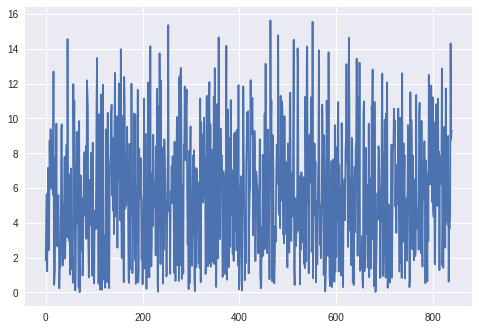

In [0]:
plt.plot(y_test_2)

In [0]:
save()

Saved model to disk


# Test Data

In [0]:
# import pickle
# output = open('X_2500x60x14.pkl', 'wb')
# pickle.dump(X, output)
# output.close()


In [0]:
# pkl_file = open('X_2500x60x14.pkl', 'rb')
# X = pickle.load(pkl_file)
# pkl_file.close()

In [0]:
import glob

files = []

for filename in glob.glob('seg_*'):
  files.append(filename)

In [0]:
# For Standart Model
all = {}

for filename in files:
  test = pd.read_csv(filename)
  X_pred = pd.DataFrame()
  ch = gen_features(test['acoustic_data'])
  X_pred = X_pred.append(ch, ignore_index=True)
  
  X_pred = sc.transform(X_pred)
  
  erg = m.predict(X_pred)
  
#   erg = gbm.predict(X_pred)
  all[filename] = erg

In [0]:
# For ANN
all = {}

for filename in files:
  test = pd.read_csv(filename)
  X_pred = pd.DataFrame()
  ch = gen_features1(test['acoustic_data'])
  X_pred = X_pred.append(ch, ignore_index=True)
  
  X_pred = sc.transform(X_pred)
  
  erg = log2[2]['model'].predict(X_pred)
  
#   erg = gbm.predict(X_pred)
  all[filename] = erg

In [0]:
# For LSTM Model
all = {}

for filename in files:
  reader_X = pd.read_csv(filename, iterator=True, chunksize=2500, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})
  X_test = pd.DataFrame()
  for df in reader_X:
      ch = gen_features(df['acoustic_data'])
      X_test = X_test.append(ch, ignore_index=True)

  X_test = X_test.as_matrix()
  X_test = scalerX.transform(X_test)
  X_test = X_test.reshape(1,60,14)  
  
  erg = model.predict(X_test)
  erg = scalerYYYYYY.inverse_transform(erg)
  all[filename] = erg

In [0]:
all

In [0]:
import csv

with open('ANN_big_1-994.csv', 'w') as f:
    for key in all.keys():
        f.write("%s,%s\n"%(key,all[key]))

In [0]:
from google.colab import files
files.download('ANN_big_1-994.csv')